In [11]:
# Install required libraries
!pip3 install transformers
!pip3 install sentencepiece
!pip3 install googletrans==3.1.0a0

# Import necessary libraries and classes
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
import multiprocessing
import matplotlib.pyplot as plt
from googletrans import Translator
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from transformers import AutoTokenizer, AutoModel, AdamW
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# Specify GPU device
device = torch.device("cuda")
torch.cuda.empty_cache()

Import the labelled dataset containing the premise, corresponding hypothesis, language of the text and relating label (entailment, neutral or contradiction). Analyze the dataset for any missing values, language or class imbalance. Also have a look at the distribution of text length in premises and hypothesis for any exception.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12120 entries, 0 to 12119
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          12120 non-null  object
 1   premise     12120 non-null  object
 2   hypothesis  12120 non-null  object
 3   lang_abv    12120 non-null  object
 4   language    12120 non-null  object
 5   label       12120 non-null  int64 
dtypes: int64(1), object(5)
memory usage: 568.2+ KB
en    6870
zh     411
ar     401
fr     390
sw     385
ur     381
vi     379
ru     376
hi     374
el     372
th     371
es     366
tr     351
de     351
bg     342
Name: lang_abv, dtype: int64
0    4176
2    4064
1    3880
Name: label, dtype: int64


<Axes: >

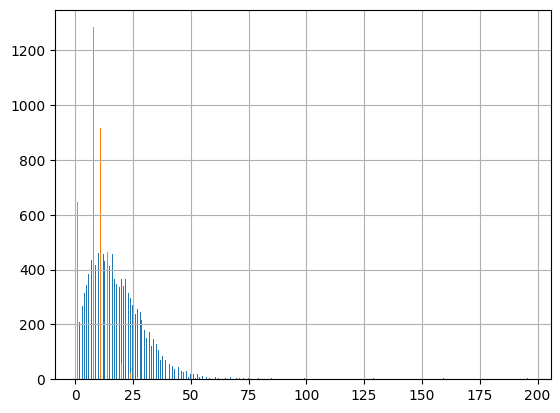

In [12]:
# Import the labelled dataset
dataset = pd.read_csv('/dataset.csv')

# Analyze the dataset
dataset.info()
print(dataset['lang_abv'].value_counts())
print(dataset['label'].value_counts())

# Visualize length of all the premises and hypothesis in the dataset
premise_len = [len(premise.split()) for premise in dataset['premise']]
pd.Series(premise_len).hist(bins=500)

hypothesis_len = [len(hypothesis.split()) for hypothesis in dataset['hypothesis']]
pd.Series(hypothesis_len).hist(bins=500)

After analyzing the dataset It is clear that there is a language imbalance. In order to minimze this, Apply text augmentation on the dominant English datapoints. **Google Translator** library is used to translate English datapoints into a different language chosen randomly from the remaining languages. Module **multiprocessing** is also employed to compute the translations in parallel because the dataset is large. Finally split the dataset into training and validation sets. <br> Note:- *One can experiment translations on the other languages as well. Back translation can also be used where the text is converted back to its original language after being translated to a different langugage chosen randomly.*


In [13]:
# Function to translate the text data
def translate(row):
    # Extract premise and hypothesis from the row
    premise_sequence, hypothesis_sequence = row[1]['premise'], row[1]['hypothesis']

    # List of relevant languages in this task
    languages = ['fr', 'th', 'tr', 'ur', 'ru', 'bg', 'de', 'ar', 'zh-cn', 'hi', 'sw', 'vi', 'es', 'el']

    # Define a google translator instance
    translator = Translator(service_urls=['translate.googleapis.com'])
    translator.raise_Exception = True

    # Randomly choose a different language for translation
    random_lang = np.random.choice([lang for lang in languages])

    # Translate to the new random language
    premise_translated = translator.translate(premise_sequence, dest=random_lang).text
    hypothesis_translated = translator.translate(hypothesis_sequence, dest=random_lang).text

    if random_lang == 'zh-cn':
        random_lang = 'zh'

    # Return the translated data
    return premise_translated, hypothesis_translated, random_lang, row[1]['label']

# Create dataframe containing the English datapoints for translation augmentation
translated_dataset = dataset[dataset['lang_abv'] == "en"].copy()

# Create a multiprocessing pool
num_processes = multiprocessing.cpu_count()
pool = multiprocessing.Pool(processes=num_processes)

# Prepare the data for parallel processing
pool_data = translated_dataset.iterrows()

# Use the pool to parallelize the computation
results = pool.map(translate, pool_data)

# Update the results in dataframe
for i, (translated_premise, translated_hypothesis, lang_abv, label) in enumerate(results):
    translated_dataset.at[i, 'premise'] = translated_premise
    translated_dataset.at[i, 'hypothesis'] = translated_hypothesis
    translated_dataset.at[i, 'lang_abv'] = lang_abv
    translated_dataset.at[i, 'label'] = label

# Close and terminate the pool
pool.close()
pool.join()

# Append the augmented data to original dataframe
dataset = dataset.append(translated_dataset)
dataset['label'] = dataset['label'].astype(int)

# Split the dataset into Training and Validation sets (stratify on language for balanced training)
train_premise, val_premise, train_hypothesis, val_hypothesis, train_labels, val_labels = train_test_split(dataset['premise'], dataset['hypothesis'], dataset['label'],
                                                                                         random_state=2023,
                                                                                         test_size=0.2,
                                                                                         stratify=dataset['lang_abv'])

<ipython-input-13-befdbbebd923>:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(translated_dataset)


In order to convert the text sequences to a form ingestible by the model, Tokenize and Encode the premises and hypothesis texts of training and validation sets using the tokenizer provided by Hugging Face compatible with the **XLM-RoBERTa** pre-trained transformer model. The XLM-R model will be used to understand the contextual information present in the texts across multiple languages. '*input_ids*' and '*attention_mask*' present in the generated tokens of premise and hypothesis will be the inputs to the model. Finally prepare the Dataloaders for model training and validation with the specified batch size.  

In [14]:
# Load the tokenizer for XLM-RoBERTa pre-trained model from Hugging Face
xlm_tokenizer = AutoTokenizer.from_pretrained('xlm-roberta-base')

# Tokenize premises text of the dataset
train_tokens_premise = xlm_tokenizer.batch_encode_plus(
    train_premise.values.tolist(),
    max_length=75,
    padding=True,
    truncation=True,
    return_token_type_ids=False)

val_tokens_premise = xlm_tokenizer.batch_encode_plus(
    val_premise.values.tolist(),
    max_length=75,
    padding=True,
    truncation=True,
    return_token_type_ids=False)

# Tokenize hypothesis text of the dataset
train_tokens_hypothesis = xlm_tokenizer.batch_encode_plus(
    train_hypothesis.values.tolist(),
    max_length=40,
    padding=True,
    truncation=True,
    return_token_type_ids=False)

val_tokens_hypothesis = xlm_tokenizer.batch_encode_plus(
    val_hypothesis.values.tolist(),
    max_length=40,
    padding=True,
    truncation=True,
    return_token_type_ids=False)

# Store datapoints required for model training
train_premise_input_ids = torch.tensor(train_tokens_premise['input_ids'])
train_premise_attention_mask = torch.tensor(train_tokens_premise['attention_mask'])
train_hypothesis_input_ids = torch.tensor(train_tokens_hypothesis['input_ids'])
train_hypothesis_attention_mask = torch.tensor(train_tokens_hypothesis['attention_mask'])
train_y = torch.tensor(train_labels.tolist())

# Store datapoints required for model validation
val_premise_input_ids = torch.tensor(val_tokens_premise['input_ids'])
val_premise_attention_mask = torch.tensor(val_tokens_premise['attention_mask'])
val_hypothesis_input_ids = torch.tensor(val_tokens_hypothesis['input_ids'])
val_hypothesis_attention_mask = torch.tensor(val_tokens_hypothesis['attention_mask'])
val_y = torch.tensor(val_labels.tolist())

# Define a batch size
batch_size = 100

# Create Dataloader for training datapoints using random sampling
train_data = TensorDataset(train_premise_input_ids, train_premise_attention_mask, train_hypothesis_input_ids,
                           train_hypothesis_attention_mask, train_y)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create Dataloader for validation datapoints using sequential sampling
val_data = TensorDataset(val_premise_input_ids, val_premise_attention_mask, val_hypothesis_input_ids,
                         val_hypothesis_attention_mask, val_y)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

Now onto defining the architecture or network of the model. Here **Siamese Architecture** is followed where the premise and hypothesis inputs are passed separately to the XLM-R model and then the results are aggregated and passed to a classification layer for final prediction. A sequential order of fully connected, normalization and activation layers are also included for additional learning as well as prediction. Dropout layer is used to reduce overfitting. **Pooling** and **Aggregation** of the outputs from the BERT model is inspired by the research paper titled '*Bert-based Siamese Network for Semantic
Similarity*'. All the parameters are fine-tuned over several training phases.

In [15]:
# Load the pre-trained XLM-RoBERTa model
xlm_bert = AutoModel.from_pretrained('xlm-roberta-base')

# Define the Model Architecture
class Model_Arch(nn.Module):
    def __init__(self, xlm_bert):
        # Call the base class constructor
        super(Model_Arch, self).__init__()

        # BERT layer
        self.bert = xlm_bert

        # Dropout layer
        self.dropout = nn.Dropout(0.5)

        # Relu activation layer
        self.relu =  nn.ReLU()

        # Batch Normalization layer
        self.bn1 = nn.BatchNorm1d(64)

        # Fully Connected layers
        self.fc1 = nn.Linear(768, 64)
        self.fc2 = nn.Linear(192, 3)

        # Softmax activation layer
        self.softmax = nn.LogSoftmax(dim=-1)

        # Random initialization of weights
        nn.init.xavier_uniform_(self.fc1.weight)
        nn.init.xavier_uniform_(self.fc2.weight)

    # Define forward pass for premise and hypothesis separately
    def forward_once(self, input_id, attention_mask):
        # Pass the inputs to the model
        bert_output = self.bert(input_id, attention_mask=attention_mask)

        # Perform Max Pooling with attention masks
        masked_hidden_state = bert_output.last_hidden_state.masked_fill(attention_mask.unsqueeze(-1) == 0, float('-inf'))
        pooled_output, _ = torch.max(masked_hidden_state, dim=1)

        # Call other layers sequentially
        output = self.dropout(pooled_output)
        output = self.fc1(output)
        output = self.bn1(output)
        output = self.relu(output)

        return output

    # Define forward pass of the model (Siamese Architecture)
    def forward(self, input_id_premise, attention_mask_premise, input_id_hypothesis, attention_mask_hypothesis):
        # Forward pass of premise
        output1 = self.forward_once(input_id_premise, attention_mask_premise)

        # Forward pass of hypothesis
        output2 = self.forward_once(input_id_hypothesis, attention_mask_hypothesis)

        # Aggregate the outputs
        output = torch.cat([output1, output2, torch.abs(output1-output2)], dim=-1)
        output = self.dropout(output)
        output = self.fc2(output)
        output = self.softmax(output)

        return output

Initialize the main model using the pre-trained XLM-R. Make sure all the parameters are unfrozen for learning. **AdamW** optimizer is used here with *weight_decay* to prevent overfitting. **CosineAnnealingLR** scheduler is used to update the learning rate of the optimizer throughout training. Finally **NLLLoss** (on top of LogSoftmax) is chosen as the loss function for this classification job along with class weights to handle class/label imbalance after augmentation.

In [16]:
# Initialize the model
model = Model_Arch(xlm_bert)

# Unfreeze parameters for training
for param in model.parameters():
    param.requires_grad = True

# Push the model to GPU
model = model.to(device)

# Specify number of training epochs
epochs = 20

# Define the optimizer
optimizer = AdamW(model.parameters(), lr=1e-5, weight_decay=0.0001)

# Define LR scheduler
scheduler = CosineAnnealingLR(optimizer, T_max=epochs, eta_min=1e-6)

# Compute the class weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(train_labels), y=train_labels)
class_weights = torch.tensor(class_weights, dtype=torch.float)
class_weights = class_weights.to(device)

# Define loss function
loss_function = nn.NLLLoss(weight=class_weights)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Define the training routine for the model. This includes iterating over the training batches and running a forward pass on the model using the batch data, calculating the loss between the actual and predicted values, backpropagating the loss to calculate gradients and then updating the model parameters using these gradients. *Gradient clipping* is used to prevent the exploding gradient problem and *LR scheduler* is called after every training epoch to update the learning rate. Accuracy and Loss are calculated for each epoch and returned in the end for performance measure during training.

In [17]:
# Function to train the model
def train():
    # Enable training mode of the model
    model.train()

    # Variables to calculate metrics
    total_loss = 0
    total_preds = []
    total_labels = []

    # Iterate over the batches
    for step, batch in enumerate(train_dataloader):
        # Update progress after every 30 batches
        if step%30 == 0 and not step == 0:
            print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))

        # Push the batch to GPU
        batch = [row.to(device) for row in batch]
        input_id_premise, attention_mask_premise, input_id_hypothesis, attention_mask_hypothesis, labels = batch

        # Clear previously calculated gradients
        optimizer.zero_grad()

        # Get model predictions for the current batch
        preds = model(input_id_premise, attention_mask_premise, input_id_hypothesis, attention_mask_hypothesis)

        # Compute the loss between actual and predicted values
        loss = loss_function(preds, labels)
        total_loss = total_loss + loss.item()

        # Backward pass to calculate the gradients
        loss.backward()

        # Clip the the gradients to 1.0 to prevent the exploding gradient problem
        grad_norms = torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters
        optimizer.step()

        # Model predictions are stored on GPU. So, push them to CPU
        preds = preds.detach().cpu().numpy()
        labels = labels.detach().cpu().numpy()

        # Append the model predictions and labels
        total_preds.append(preds)
        total_labels.append(labels)

    # Call the scheduler
    scheduler.step()

    # Compute the training loss of this epoch
    avg_loss = total_loss/len(train_dataloader)

    # Reshape the predictions and labels
    total_preds = np.concatenate(total_preds, axis=0)
    total_preds = np.argmax(total_preds, axis=1)
    total_labels = np.concatenate(total_labels, axis=0)

    # Compute accuracy of this epoch
    accuracy = accuracy_score(total_labels, total_preds)
    print(f'\n Training accuracy: {accuracy:.3f}')

    # Return the loss and accuracy
    return avg_loss, accuracy

Define the validation routine for the model after every training epoch. This basically includes iterating over the validation batches, then getting the model predictions for each batch and consequently calculating the loss between the actual and predicted values for model evaluation on unseen data. Accuracy and Loss are calculated for the validation set and returned in the end for performance measure.

In [18]:
# Function for evaluating the model
def evaluate():
    print("\n Evaluating...")

    # Enable validation mode of the model
    model.eval()

    # Variables needed to compute metrics
    total_loss = 0
    total_labels = []
    total_preds = []

    # Iterate over the batches
    for step, batch in enumerate(val_dataloader):
        # Update progress after every 20 batches
        if step%20 == 0 and not step == 0:
            print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))

        # Push the batch to GPU
        batch = [row.to(device) for row in batch]
        input_id_premise, attention_mask_premise, input_id_hypothesis, attention_mask_hypothesis, labels = batch

        # Deactivate autograd
        with torch.no_grad():
            # Model predictions on input
            preds = model(input_id_premise, attention_mask_premise, input_id_hypothesis, attention_mask_hypothesis)

            # Compute the validation loss between actual and predicted values
            loss = loss_function(preds, labels)
            total_loss = total_loss + loss.item()

            # Detach output and labels from GPU and push them to CPU
            preds = preds.detach().cpu().numpy()
            labels = labels.detach().cpu().numpy()

            # Append the predictions and labels
            total_preds.append(preds)
            total_labels.append(labels)

    # Compute the validation loss of this epoch
    avg_loss = total_loss/len(val_dataloader)

    # Reshape the predictions and labels
    total_preds = np.concatenate(total_preds, axis=0)
    total_preds = np.argmax(total_preds, axis=1)
    total_labels = np.concatenate(total_labels, axis=0)

    # Compute accuracy of this epoch
    accuracy = accuracy_score(total_labels, total_preds)
    print(f'\n Validation accuracy: {accuracy:.3f}')

    return avg_loss, accuracy

Finally iterate over the specified number of epochs and train the model. Validation is called after training in each epoch to assess the model's performance on unseen data.

In [19]:
# Store variables for analysis
train_accuracies = []
valid_accuracies = []

# Start model training and corresponding validations
for epoch in range(epochs):
    print('\nEpoch {:} / {:}'.format(epoch + 1, epochs))

    # Train the model
    train_loss, train_accuracy = train()

    # Evaluate the model
    valid_loss, valid_accuracy = evaluate()

    # Print the metrics
    print(f'\n Training Loss: {train_loss:.3f}')
    print(f' Validation Loss: {valid_loss:.3f}')

    # Append the accuracies
    train_accuracies.append(train_accuracy)
    valid_accuracies.append(valid_accuracy)


Epoch 1 / 20
  Batch    30  of    176.
  Batch    60  of    176.
  Batch    90  of    176.
  Batch   120  of    176.
  Batch   150  of    176.

 Training accuracy: 0.333

 Evaluating...
  Batch    20  of     44.
  Batch    40  of     44.

 Validation accuracy: 0.347

 Training Loss: 1.694
 Validation Loss: 1.114

Epoch 2 / 20
  Batch    30  of    176.
  Batch    60  of    176.
  Batch    90  of    176.
  Batch   120  of    176.
  Batch   150  of    176.

 Training accuracy: 0.337

 Evaluating...
  Batch    20  of     44.
  Batch    40  of     44.

 Validation accuracy: 0.351

 Training Loss: 1.587
 Validation Loss: 1.086

Epoch 3 / 20
  Batch    30  of    176.
  Batch    60  of    176.
  Batch    90  of    176.
  Batch   120  of    176.
  Batch   150  of    176.

 Training accuracy: 0.374

 Evaluating...
  Batch    20  of     44.
  Batch    40  of     44.

 Validation accuracy: 0.391

 Training Loss: 1.468
 Validation Loss: 1.051

Epoch 4 / 20
  Batch    30  of    176.
  Batch    60  

Plot the training and validation accuracies against the epochs to get a visual interpretation of the model's learning process and turning points.

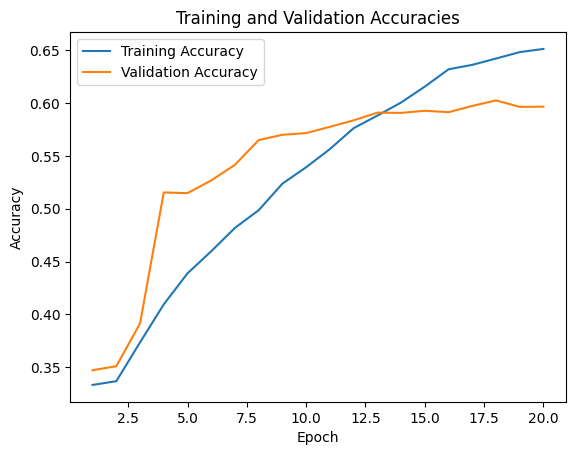

In [20]:
epochs_list = list(range(1, epochs + 1))
# Plot training and validation accuracies
plt.plot(epochs_list, train_accuracies, label='Training Accuracy')
plt.plot(epochs_list, valid_accuracies, label='Validation Accuracy')

# Add labels and title
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracies')
plt.legend()

# Display the plot
plt.show()